In [144]:
import matplotlib.pyplot as plt
import torch
from torch.quasirandom import SobolEngine

import numpy as np
from alse.accuracy import get_accuracy
from alse.utils import identify_samples_which_satisfy_constraints, store_param, transform, un_transform
from mpl_toolkits import mplot3d
# from matplotlib import cm
from alse.print_workflow.read_excel_fixed_feed import read_excel
from alse.print_workflow.init_model import initialize_models
from alse.print_workflow.generate_test_points_fixed_feed import generate_test_points

In [145]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

Read data

In [146]:
X, width, pow_cap, wth = read_excel()

Name for the excel sheets are hardcoded in this version


In [147]:
Xman, width, pow_cap, wth = read_excel()

Name for the excel sheets are hardcoded in this version


In [148]:
X.shape

torch.Size([20, 2])

In [149]:
manual_N = 20

In [150]:
X = X[:manual_N]
width = width[:manual_N]
pow_cap = pow_cap[:manual_N]
wth = wth[:manual_N]

In [151]:
import ipympl

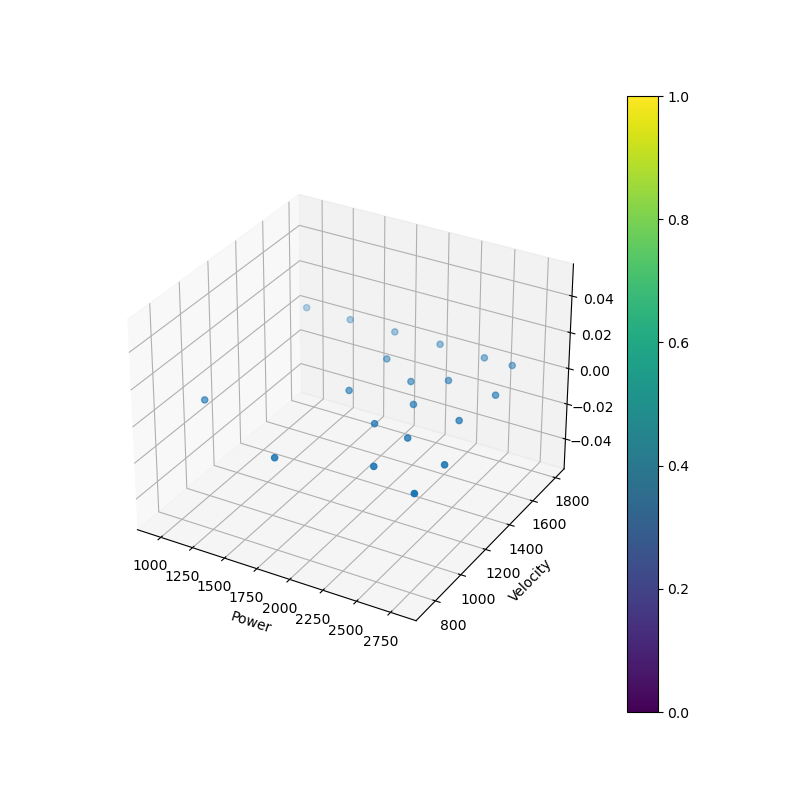

In [152]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel("Power")
ax.set_ylabel("Velocity")
# ax.set_zlabel("Spot size")
# ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3])
img = ax.scatter(X[:,0], X[:,1])
fig.colorbar(img)
plt.show()

In [153]:
# Store for un_transform later
xrange_list, xmin_list = store_param(X, 2)

In [154]:
bounds = torch.tensor([[900, 2700], [600, 1800]], **tkwargs)

In [155]:
X = transform(X, 2, bounds)

# You can verify the Normalization is correct by undoing the above step and comparing to original data
# X = un_transform(X, xrange_list, xmin_list, 4) 

In [156]:
list_of_models = initialize_models(X, width, pow_cap, wth) # You can put in arbitrary amount of output parameters

In [157]:
punchout_radius = 0.1
bounds = torch.tensor([[0, 0], [1, 1]], **tkwargs) # Because we normalized
# bounds = torch.tensor([[-0.082,-0.122], [1.074,1.01]], **tkwargs)
lb, ub = bounds


In [158]:
constraints = [("gt", 2.5), ("gt", 0.5), ("gt", 6)]
# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std

In [159]:
# How many new points do we want
num_pred = 5
Ytemp = [width, pow_cap, wth] #Store temps for test point generation

In [160]:
# un_transform(torch.tensor([[1.074,1.01]]), xrange_list, xmin_list, 2)

Max power: 2700W
Min power: 900W
Max speed: 1800 mm/min
Min speed: 600 mm/min

In [161]:
xmin_list = torch.tensor([900, 600])


In [162]:
xrange_list = torch.tensor([1800, 1200])

In [163]:
X = generate_test_points(X, num_pred, Ytemp, constraints, punchout_radius, bounds)

X = un_transform(X, xrange_list, xmin_list, 2)

x_next: tensor([[0.9269, 0.0000]])
acq_val: 0.5244909561847784
x_next: tensor([[0.4899, 0.3882]])
acq_val: 0.49008162505895564
x_next: tensor([[1.0000, 0.4809]])
acq_val: 0.49835946312709034
x_next: tensor([[0.7361, 0.0000]])
acq_val: 0.4881864713145385
x_next: tensor([[0.3268, 0.0000]])
acq_val: 0.40157723190310485


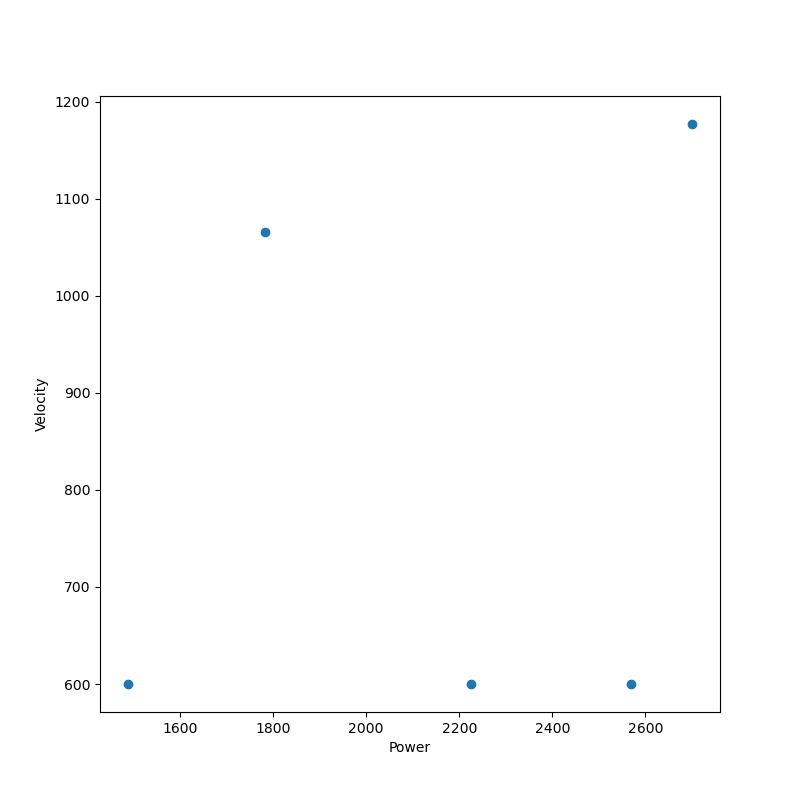

In [164]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.set_xlabel("Power")
ax.set_ylabel("Velocity")
# ax.set_zlabel("Spot size")
# ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3])
# img = ax.scatter(X[:manual_N,0], X[:manual_N,1], c='r')
img = ax.scatter(X[manual_N:,0], X[manual_N:,1])
plt.show()

In [165]:
new_N_points = X[-num_pred:]
for i in range(new_N_points.shape[0], 0, -1):
    new_power = round(X[-i][0].item(), 2)
    new_velocity = round(X[-i][1].item(), 2)
    # new_spotsize = round(X[-i][2].item(), 2)
    # new_feedrate = round(X[-i][3].item(), 2)
    print(f"New X_{new_N_points.shape[0]+1-i}: Power: {new_power}W, Velocity: {new_velocity}mm/min")

New X_1: Power: 2568.37W, Velocity: 600.0mm/min
New X_2: Power: 1781.8W, Velocity: 1065.88mm/min
New X_3: Power: 2700.0W, Velocity: 1177.03mm/min
New X_4: Power: 2224.89W, Velocity: 600.0mm/min
New X_5: Power: 1488.19W, Velocity: 600.0mm/min


In [166]:
feasible_inds_width = (
    identify_samples_which_satisfy_constraints(width, constraints[0])
    .prod(dim=-1)
    .to(torch.bool)
)

In [167]:
feasible_inds_pow_cap = (
    identify_samples_which_satisfy_constraints(pow_cap, constraints[1])
    .prod(dim=-1)
    .to(torch.bool)
)

In [168]:
feasible_inds_wth = (
    identify_samples_which_satisfy_constraints(wth, constraints[2])
    .prod(dim=-1)
    .to(torch.bool)
)

In [169]:
# Xplt = X[:10,:]

In [170]:
# plt.scatter(X.float().numpy()[manual_N:, 0], X.float().numpy()[manual_N:, 1])
# # plt.plot(Xplt[feasible_inds_width, 0].cpu(), Xplt[feasible_inds_width, 1].cpu(), "og")
# # plt.plot(Xplt[feasible_inds_wth, 0].cpu(), Xplt[feasible_inds_wth, 1].cpu(), "og")
# # plt.scatter(X.float().numpy()[5:, 0], X.float().numpy()[5:, 1], color='k')
# plt.show()

In [171]:
N1, N2 = 200, 200
Xplt, Yplt = torch.meshgrid(
    torch.linspace(0, 1, N1, **tkwargs), torch.linspace(0, 1, N2, **tkwargs),
    indexing='xy',
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)
Xplt, Yplt = torch.meshgrid(
    torch.linspace(900, 2700, N1, **tkwargs), torch.linspace(600, 1800, N2, **tkwargs),
    indexing='xy',
)

In [172]:
xplt = xplt.double()

In [173]:
# Xplt = un_transform(Xplt.clone(), xrange_list, xmin_list, 2).double()

In [174]:
Xtemp = X[:manual_N]

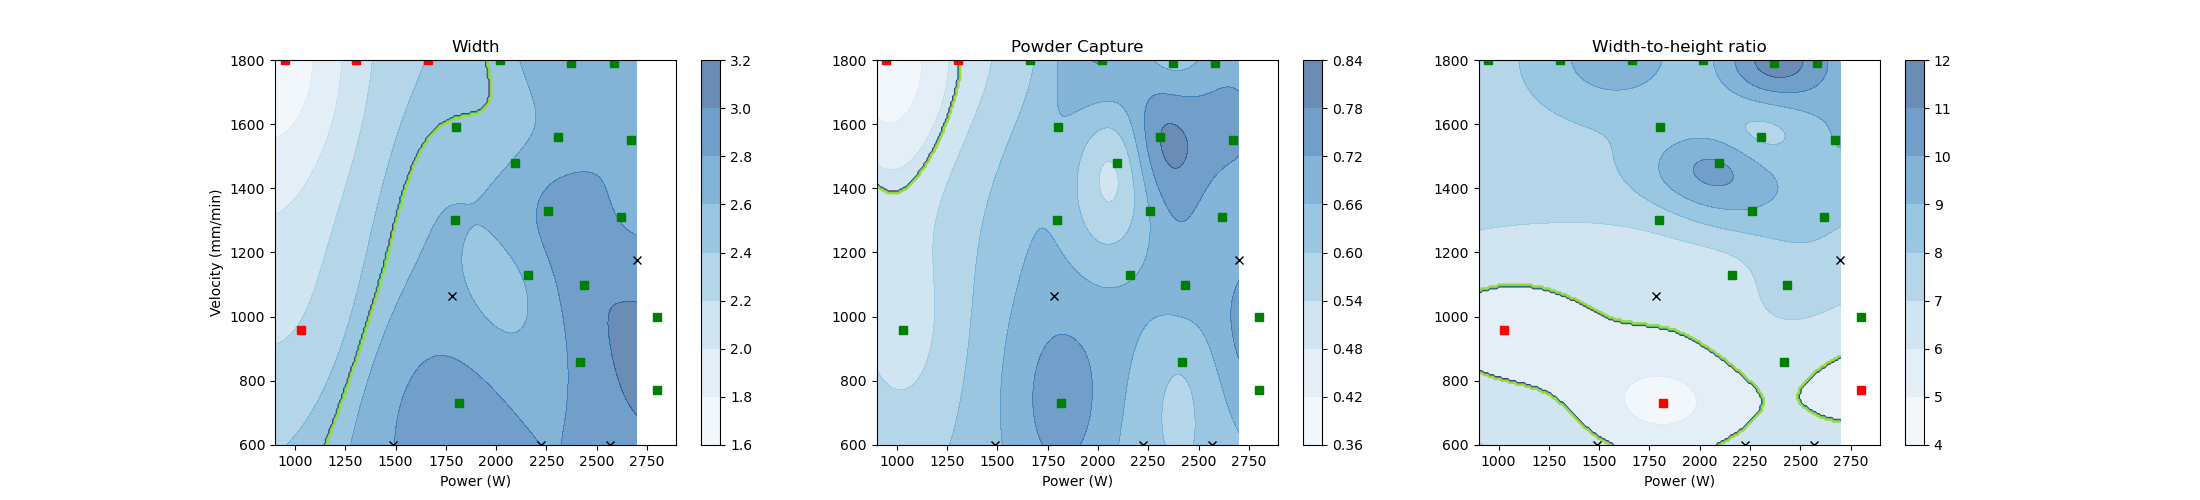

In [175]:
# plt.subplots(3, figsize=(8, 8))
predicted_width = list_of_models[0](xplt).loc.detach().reshape(N1,N2)
predicted_pow_cap = list_of_models[1](xplt).loc.detach().reshape(N1,N2)
predicted_wth = list_of_models[2](xplt).loc.detach().reshape(N1,N2)

est_width = predicted_width > 2.5
est_pow_cap = predicted_pow_cap > 0.5
est_pow_cap2 = predicted_pow_cap > 0.65
est_wth = predicted_wth > 6

reference = (est_width & est_pow_cap & est_wth)
plt.figure(1)

fig, ax = plt.subplots(1,3, figsize=(22, 5))
# Xplt = un_transform(Xplt, xrange_list, xmin_list, 2)
plot1 = ax[0].contourf(Xplt, Yplt, predicted_width,cmap="Blues", alpha=0.6)
ax[0].contour(Xplt, Yplt, est_width)
ax[0].plot(Xtemp[feasible_inds_width, 0], Xtemp[feasible_inds_width, 1], "sg", label="In Boundary")
ax[0].plot(Xtemp[~feasible_inds_width, 0], Xtemp[~feasible_inds_width, 1], "sr", label="Out of Boundary")
ax[0].plot(X[-5:, 0], X[-5:, 1], "kx")
fig.colorbar(plot1, ax=ax[0])

plot2 = ax[1].contourf(Xplt, Yplt, predicted_pow_cap,cmap="Blues", alpha=0.6)
ax[1].contour(Xplt, Yplt, est_pow_cap)
# ax[1].contour(Xplt.cpu(), Yplt.cpu(), est_pow_cap2.cpu())
# ax[1].scatter(X.float().numpy()[:, 0], X.float().numpy()[:, 1])
ax[1].plot(Xtemp[feasible_inds_pow_cap, 0], Xtemp[feasible_inds_pow_cap, 1], "sg", label="In Boundary")
ax[1].plot(Xtemp[~feasible_inds_pow_cap, 0], Xtemp[~feasible_inds_pow_cap, 1], "sr", label="Out of Boundary")
ax[1].plot(X[-5:, 0], X[-5:, 1], "kx")
fig.colorbar(plot2, ax=ax[1])

plot3 = ax[2].contourf(Xplt, Yplt, predicted_wth,cmap="Blues", alpha=0.6)
ax[2].contour(Xplt, Yplt, est_wth)
ax[2].plot(Xtemp[feasible_inds_wth, 0], Xtemp[feasible_inds_wth, 1], "sg", label="In Boundary")
ax[2].plot(Xtemp[~feasible_inds_wth, 0], Xtemp[~feasible_inds_wth, 1], "sr", label="Out of Boundary")
ax[2].plot(X[-5:, 0], X[-5:, 1], "kx")
fig.colorbar(plot3, ax=ax[2])
# ax[0].contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu())

# plt.contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu(), cmap="Blues", alpha=0.6)
ax[0].set_xlabel('Power (W)')
ax[1].set_xlabel('Power (W)')
ax[2].set_xlabel('Power (W)')
ax[0].set_ylabel('Velocity (mm/min)')
ax[0].set_title('Width')
ax[1].set_title('Powder Capture')
ax[2].set_title('Width-to-height ratio')



plt.show()

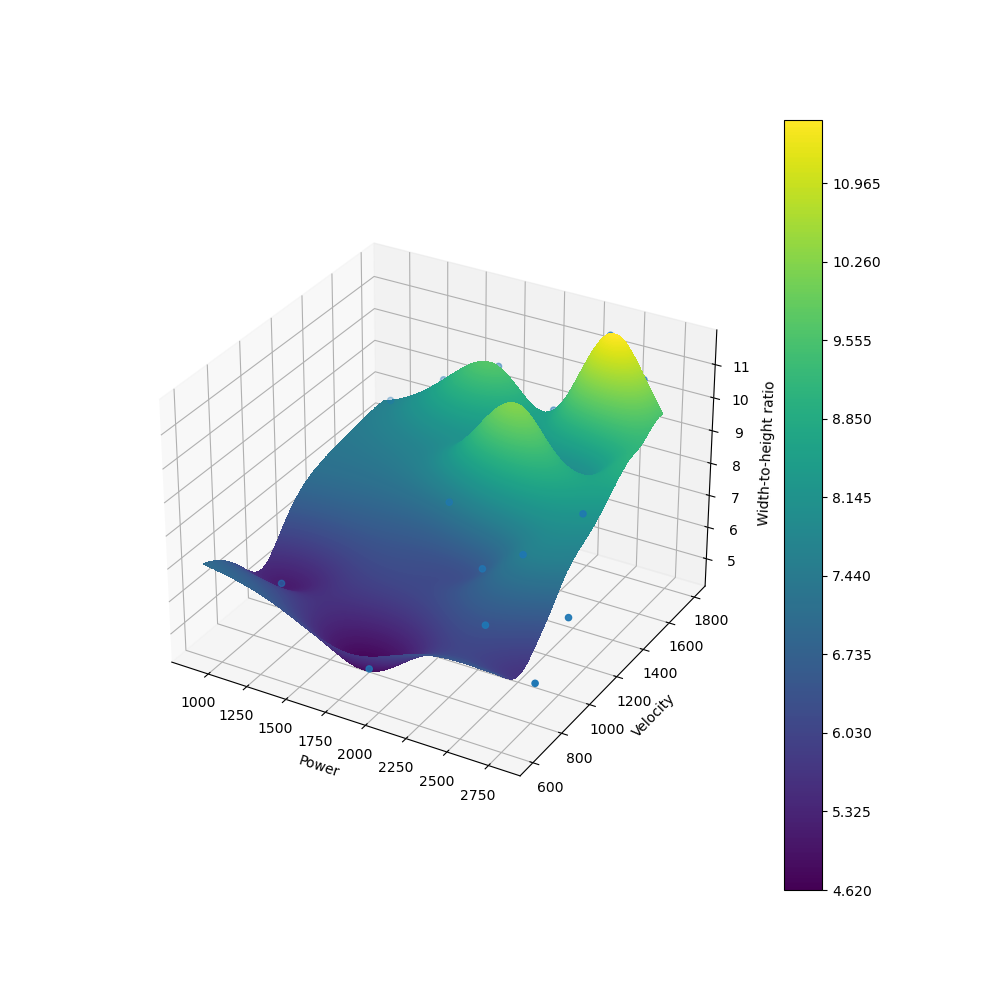

In [176]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
# ax.set_title("Powder capture")
ax.set_xlabel("Power")
ax.set_ylabel("Velocity")
ax.set_zlabel("Width-to-height ratio")
# ax.set_zlabel("Spot size")
ax.scatter(X[:manual_N,0], X[:manual_N,1], wth)
img = ax.contourf(Xplt, Yplt, predicted_wth, 500)
# img = ax.contourf(Xplt, Yplt, predicted_pow_cap, levels=torch.linspace(0.4,0.8,150))
# img = ax.contourf(Xplt, Yplt, predicted_pow_cap, levels=torch.linspace(0.4,0.8,150))
fig.colorbar(img)
plt.show()

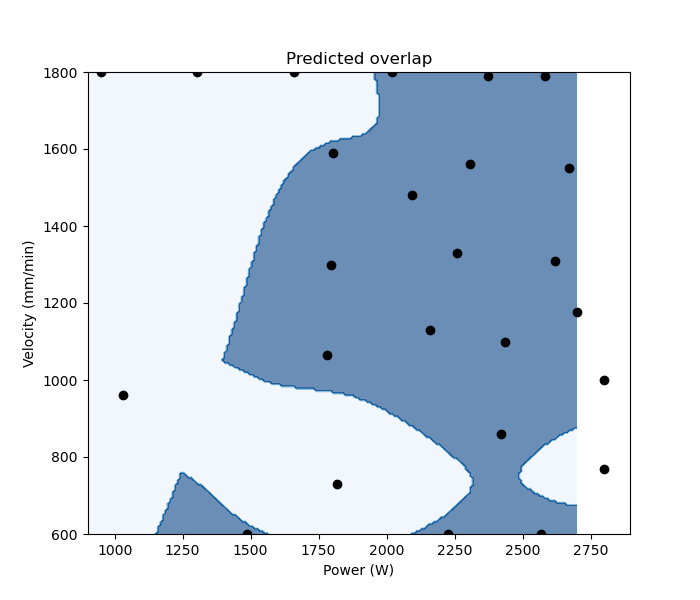

In [177]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu(),cmap="Blues", alpha=0.6)
ax.scatter(X.float().numpy()[:, 0], X.float().numpy()[:, 1], color='k')
ax.set_title('Predicted overlap')
ax.set_xlabel('Power (W)')
ax.set_ylabel('Velocity (mm/min)')
plt.show()

In [178]:
# fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection='3d')
# ax.set_xlabel("Power")
# ax.set_ylabel("Velocity")
# ax.set_zlabel("Spot size")
# # ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3])
# img = ax.scatter(X[:-num_pred,0], X[:-num_pred,1], X[:-num_pred,2], c=X[:-num_pred,3])
# img = ax.scatter(X[-num_pred:,0], X[-num_pred:,1], X[-num_pred:,2], c=X[-num_pred:,3], marker = "x")
# fig.colorbar(img)
# plt.show()